In [1]:
%matplotlib notebook

In [2]:
import pyglow
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import optimize
import pandas as pd
import seaborn as sns
import importlib
import unicodedata
import networkx as nx

plt.style.use('seaborn')

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

In [4]:
import steve
importlib.reload(steve)

import steve_reactions

#### Load reaction rate coefficient expressions and other information

In [5]:
df = pd.read_csv('rates.csv')

In [6]:
df

,#,Reaction,Rate,Src0,Src1
0,1.0,N2+ + O → NO+ + N(2D),if Ti<1500:\n(1-0.07*xi**0.21) * 1.4e-10*xi**-...,G18,NaN
1,39.0,N2+ + O → O+ + N2,if Ti<1500:\n0.07*xi**0.21 * 1.4e-10*xi**-0.44...,G18,NaN
2,2.0,N2+ + O2 → N2 + O2+,5.0e-11*xi**-0.8,G18,NaN
3,3.0,N2+ + e → N(2D) + N,if Te<1200:\n0.88*2.2e-7*xe**-0.39\nif Te>=120...,G18,NaN
4,72.0,N2+ + e → N(2D) + N(2D),if Te<1200:\n0.12*2.2e-7*xe**-0.39\nif Te>=120...,G18,NaN
5,4.0,O+ + N2 → NO+ + N,if Tf<3725:\n1.71676e-12 - 7.19934e-13*xf + 1....,NaN,SL98
6,5.0,O+ + O2 → O2+ + O,if Tf<4800:\n2.78932e-11 - 6.92612e-12*xf + 8....,NaN,SL98
7,6.0,O+ + NO → NO+ + O,if Tf<3800:\n6.40408e-13 - 1.33888e-13*xf + 7....,NaN,SL98
8,9.0,O2+ + NO → NO+ + O2,4.1e-10,G18,NaN
9,67.0,O2+ + N2 → NO+ + NO,5e-16,G18,NaN


#### Define reactions and species

In [7]:
species, emissions, din, dout, demis, nin, nout, nemis, sidx = steve.reaction_input_output(df)
species_ions = [s for s in species if '+' in s]
species_neutrals = [s for s in species if not '+' in s and s!='e']
reactions = list(din.keys())

In [8]:
species

array(['N', 'N(2D)', 'N+', 'N2', 'N2(v>11)', 'N2+', 'NO', 'NO+', 'O',
       'O(1D)', 'O(1S)', 'O+', 'O2', 'O2+', 'e'], dtype='<U8')

In [9]:
emissions

array(['hv2972A', 'hv5200A', 'hv5577A', 'hv6300A'], dtype='<U7')

In [10]:
reactions

['N2+ + O → NO+ + N(2D)',
 'N2+ + O → O+ + N2',
 'N2+ + O2 → N2 + O2+',
 'N2+ + e → N(2D) + N',
 'N2+ + e → N(2D) + N(2D)',
 'O+ + N2 → NO+ + N',
 'O+ + O2 → O2+ + O',
 'O+ + NO → NO+ + O',
 'O2+ + NO → NO+ + O2',
 'O2+ + N2 → NO+ + NO',
 'N2+ + NO → NO+ + N2',
 'O2+ + N → NO+ + O(1S)',
 'O2+ + N → NO+ + O(1D)',
 'O2+ + e → O(1D) + O',
 'O2+ + e → O(1D) + O(1D)',
 'O2+ + e → O(1D) + O(1S)',
 'N+ + O2 → O2+ + N',
 'N+ + O2 → O2+ + N(2D)',
 'O2+ + N(2D) → N+ + O2',
 'N+ + O2 → NO+ + O(1D)',
 'N+ + O2 → NO+ + O',
 'N+ + O2 → O+ + NO',
 'N+ + NO → NO+ + N',
 'N+ + NO → N2+ + O',
 'N+ + O → O+ + N',
 'NO+ + e → O + N(2D)',
 'NO+ + e → O + N',
 'N + O2 → NO + O',
 'N + O → NO',
 'N(2D) + O2 → NO + O',
 'N(2D) + O2 → NO + O(1D)',
 'N(2D) + N2 → N + N2',
 'N(2D) + e → N + e',
 'N(2D) + O → N + O',
 'N(2D) + O → N + O(1D)',
 'N(2D) + O → NO+ + e',
 'N(2D) + O+ → N+ + O',
 'N + NO → N2 + O',
 'N(2D) + NO → N2 + O',
 'N(2D) + NO → N + NO',
 'O + e → O(1D) + e',
 'O(1D) + N2 → O + N2',
 'O(1D) + O

#### Setup grid and initialize densities/temperatures

In [11]:
dz = 1.0

alts = np.arange(110, 500, dz)
Nz = len(alts)
Ns = len(species)
Ne = len(emissions)
Nr = len(reactions)

# Use Gillies et al (2019) event time and location
lat = 50.998
lon = -107.15
t_ref = datetime(2018,4,10,6,30,45) 

### Species concentrations [cm^-3]
n = np.zeros((Nz,Ns))

### Temperatures
Tn = np.zeros(Nz)
Te = np.zeros(Nz)
Ti = np.zeros(Nz)
Tf = np.zeros(Nz) # To be calculated for each species

### Initialize densities and temperatures
for i in range(Nz):
    pt = pyglow.Point(t_ref, lat, lon, alts[i])
    pt.run_msis()
    pt.run_iri()
    
    n[:,sidx['O']][i] = pt.nn['O']
    n[:,sidx['O2']][i] = pt.nn['O2']
    n[:,sidx['N2']][i] = pt.nn['N2']
    n[:,sidx['N']][i] = pt.nn['N']
    n[:,sidx['NO']][i] = 0. # not in MSIS
    
    n[:,sidx['O+']][i] = pt.ni['O+']
    n[:,sidx['O2+']][i] = pt.ni['O2+']
    n[:,sidx['NO+']][i] = pt.ni['NO+']
    n[:,sidx['N2+']][i] = 0. # not in IRI
    n[:,sidx['N+']][i] = 0. # not in pyglow wrapper for IRI
    n[:,sidx['e']][i] = pt.ne
    
    Tn[i] = pt.Tn_msis
    Ti[i] = pt.Ti
    Te[i] = pt.Te
    
### Initialize velocity
# Constant value for now
# Zero for now -- this is not well known and mostly affects ion recombination, not neutral chemistry
v = np.zeros(Nz)

Tnmsis = Tn.copy()
nmsis = n.copy()

### For simplicity set Tn=Te=Ti
Te = Tn.copy()
Ti = Tn.copy()

<IPython.core.display.Javascript object>


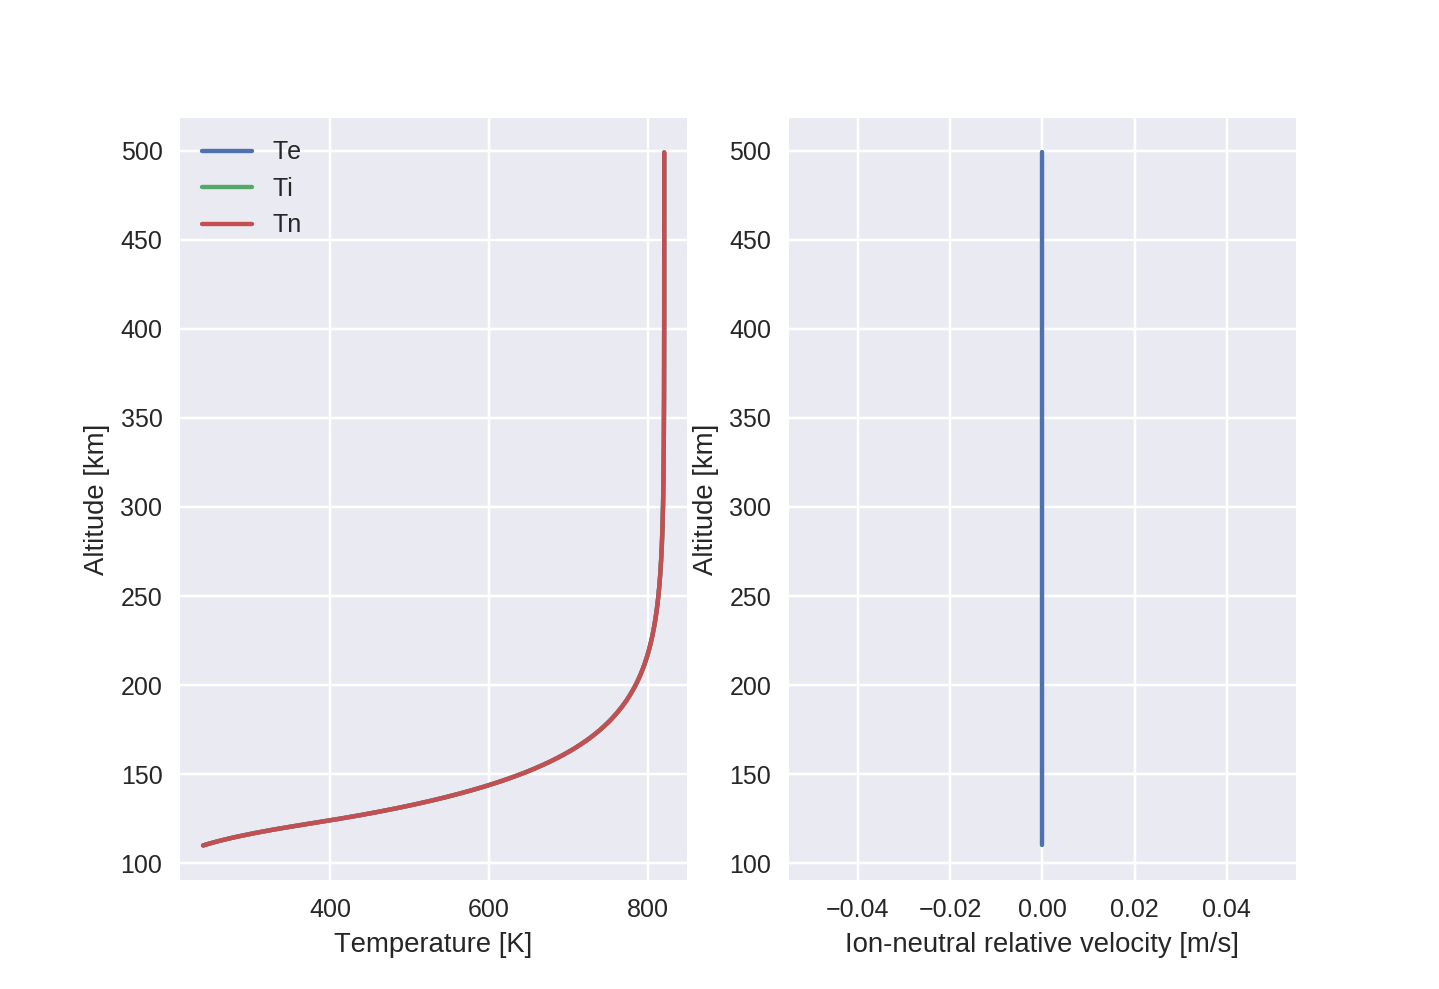

No handles with labels found to put in legend.


In [12]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(Te, alts, label='Te')
plt.plot(Ti, alts, label='Ti')
plt.plot(Tn, alts, label='Tn')
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.legend()

plt.subplot(1,2,2)
plt.plot(v, alts)
plt.xlabel('Ion-neutral relative velocity [m/s]')
plt.ylabel('Altitude [km]')
plt.legend()



In [13]:
### Print production and loss mechanisms for a species of interest
s = 'N' # or 'O' or 'N+', etc.

print('Production')
drc = steve_reactions.rate_coeff(Tn, Ti, Te, v)
for rx in dout.keys():
    if s in dout[rx] and s not in din[rx]:
        print('%s \t %.1e' % (rx, drc[rx].sum()))

print()
print('Loss')
for rx in din.keys():
    if s in din[rx] and s not in dout[rx]:
        print('%s \t %.1e' % (rx, drc[rx].sum()))

Production
N2+ + e → N(2D) + N 	 5.3e-05
O+ + N2 → NO+ + N 	 2.5e-10
N+ + O2 → O2+ + N 	 7.5e-08
N+ + NO → NO+ + N 	 1.2e-07
N+ + O → O+ + N 	 8.6e-10
NO+ + e → O + N 	 1.8e-05
N(2D) + N2 → N + N2 	 2.0e-11
N(2D) + e → N + e 	 3.2e-07
N(2D) + O → N + O 	 4.9e-10
N(2D) + O → N + O(1D) 	 5.5e-11
N(2D) + NO → N + NO 	 2.6e-08
N+ + e → N 	 6.6e-10
N(2D) → N + hv5200A 	 2.6e-03
N2(v>11) + O → NO + N 	 3.9e-09

Loss
O2+ + N → NO+ + O(1S) 	 9.7e-09
O2+ + N → NO+ + O(1D) 	 5.5e-08
N + O2 → NO + O 	 6.1e-11
N + O → NO 	 4.7e-15
N + NO → N2 + O 	 3.4e-08


In [14]:
# Colors from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/ 
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',
          '#f032e6', '#bcf60c', '#fabebe', '#008080', '#9a6324', 
          '#800000', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']

<IPython.core.display.Javascript object>


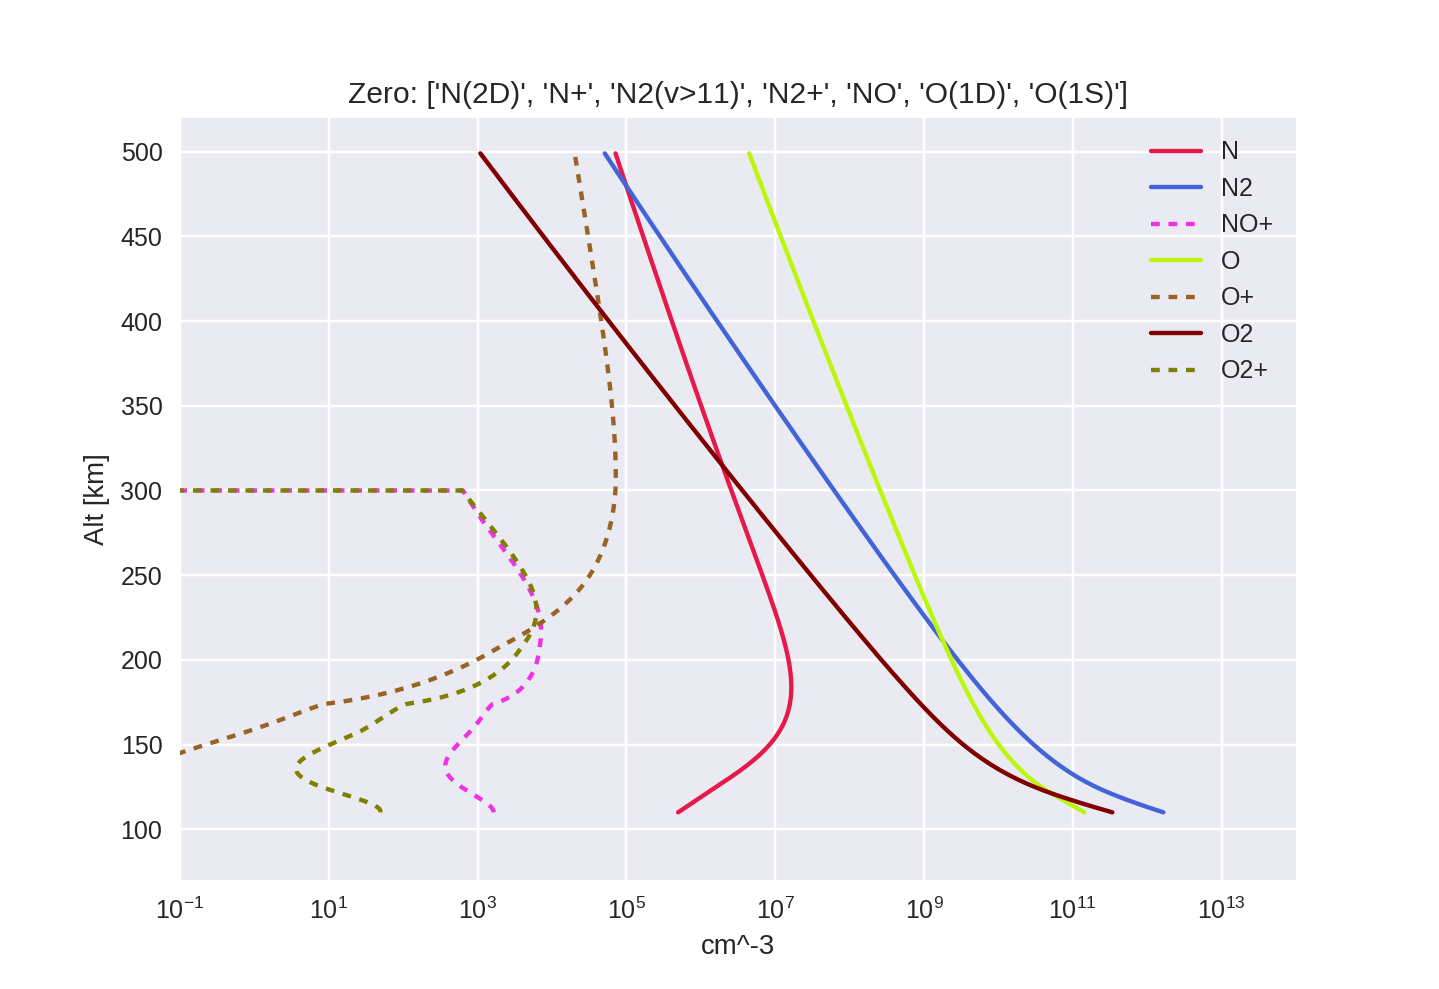

(70, 520)

In [15]:
plt.figure()

z = []
for js,s in enumerate(species):
    if sum(n[:,js]) == 0: # Note that density is zero
        plt.semilogx(0,0, 'k-')
        z.append(s)
    elif s in species_ions:
        plt.semilogx(n[:,js], alts, '--', color=colors[js%len(colors)], dashes=(2,2), label=s)
    elif s in species_neutrals:
        plt.semilogx(n[:,js], alts, '-', color=colors[js%len(colors)], label=s)
    
plt.title('Zero: %s' % z)
plt.legend()
plt.xlabel('cm^-3')
plt.ylabel('Alt [km]')
plt.xlim((1e-1, 1e14))
plt.ylim((70,520))

In [16]:
### Extrapolate O2+ and NO+ above 300 km
i0 = (alts > 275) & (alts < 300) # use to fit line
i1 = alts>=300 # where to extrapolate
for s in ['NO+', 'O2+']:
    p = np.polyfit(alts[i0], np.log(n[i0,sidx[s]]), 1)
    n[i1,sidx[s]] = np.exp(np.polyval(p, alts[i1]))
    
### Equilibrium concentrations to initialize minor species
# This order was chosen by running the model to pseudo-equilibrium,
# then investigating the production/loss balance to see which species
# are controlling the production and loss of each minor species. This
# ordering captures all of the important reactions, and ensures an important
# species is not needed before it is calculated.

drc = steve_reactions.rate_coeff(Tn, Ti, Te, v)
for s in ['NO', 'N(2D)', 'O(1S)', 'O(1D)', 'N+', 'N2+']:
    n[:,sidx[s]]    = steve.eq_dens(s, n, drc, nin, nout, species)

# ### Ensure neutrality
n[:,sidx['e']] = sum(np.array([n[:,sidx[s]] for s in species_ions]))# quasi-neutrality

<IPython.core.display.Javascript object>


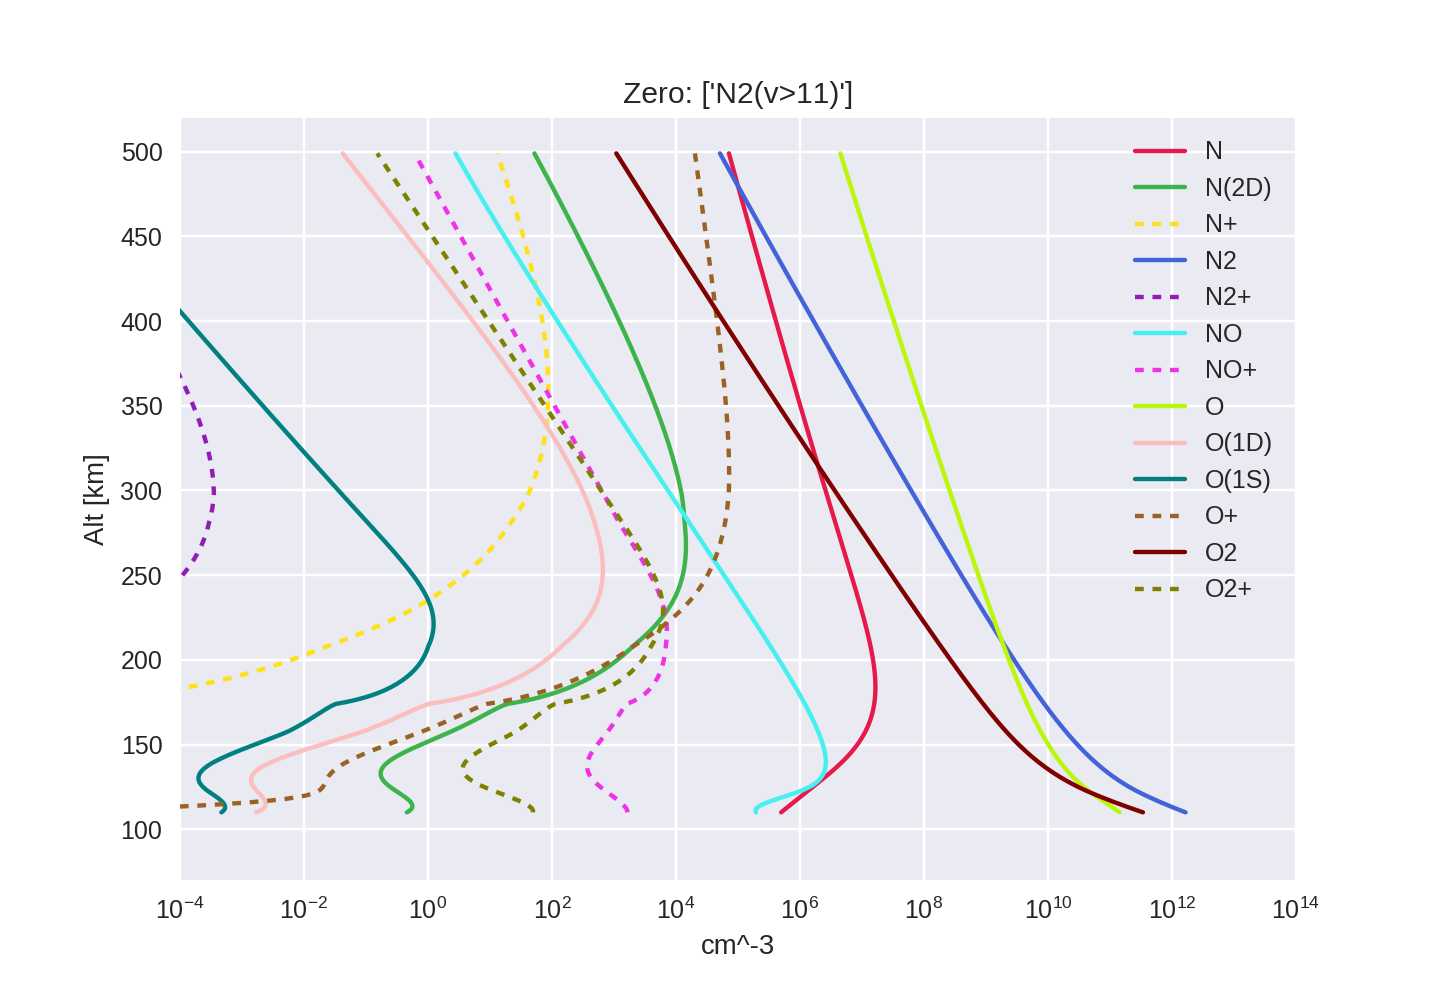

(70, 520)

In [17]:
plt.figure()

# Tn = Tnsave.copy()
# n = nsave.copy()

z = []
for js,s in enumerate(species):
    if sum(n[:,js]) == 0: # Note that density is zero
        plt.semilogx(0,0, 'k-')
        z.append(s)
    elif s in species_ions:
        plt.semilogx(n[:,js], alts, '--', color=colors[js%len(colors)], dashes=(2,2), label=s)
    elif s in species_neutrals:
        plt.semilogx(n[:,js], alts, '-', color=colors[js%len(colors)], label=s)
    
plt.title('Zero: %s' % z)
plt.legend()
plt.xlabel('cm^-3')
plt.ylabel('Alt [km]')
plt.xlim((1e-4, 1e14))
plt.ylim((70,520))

In [18]:
nsave = n.copy()
Tnsave = Tn.copy()
Tisave = Ti.copy()
Tesave = Te.copy()
vsave = v.copy()

# Now we have a realistic atmosphere. Run it in time.

In [19]:
### Uncomment this to run the case without N production
# nout['N2(v>11) + O → NO + N'] = np.array([sidx['N'], sidx['NO']])
# nout['N2(v>11) + O → NO + N'] = np.array([sidx['NO']])

In [20]:
max_steps = 20000
max_t = 400
dt = 1. # Timestep decision could be changed in the future. O(1S) and O(1D) chemistry goes unstable > 1 sec or so

########### Reload initial densities, etc. #############
n = nsave.copy() # Load starting point again
Te = Tesave.copy()
Tn = Tnsave.copy()
Ti = Tisave.copy()
v = vsave.copy()
drc = steve_reactions.rate_coeff(Tn, Ti, Te, v)

nN2v = np.zeros(Nz)

########## RUN ##############
# Time histories to save
tT = []
nT = []
dndtT = []
verT = []
TnT = []
TiT = []
TeT = []
vT = []
verfullT = [] # This will get hefty
dndtfullT = [] # This will get hefty
rateN2vO = [] # Rate of N2v + O --> NO + N

t = 0 # sec
step = 0

while (step < max_steps and t < max_t):
    
    ############# Define time history of drivers ###########
    if t==98: # At time 98
        ### Increase temperature and scale height of major netural species
        i = np.argmin(abs(alts-130.)) # Above 130 km we can be sure that chemical effects on O are negligible 
                                      # and thus major species are in diffusive equilibrium.
                                      # If a lower value is used, then the diffusive equilibrium density profiles deviate significantly from MSIS
        Tn[i:] = Tn[i:] + 3.4*(Tn[i:] - Tn[i]) # Using 3.4 puts the exospheric temperature at 2000 K
        # Adjust major neutral species
        for s,m in zip(['O','O2','N2'], [16, 32, 28]):
            H = 1.38e-23*Tn/(m*1.67e-27*9.5)*1e-3 # scale height
            dz = alts[1]-alts[0]
            e = np.cumsum(dz/H[i:])
            j = sidx[s]
            n[i:,j] = n[i-1,j] * np.exp(-e)
        
        # Not self-consistent calcluation of Ti, Te: just set equal to Tn: 
        Ti = Tn.copy()
        Te = Tn.copy()
        
        drc = steve_reactions.rate_coeff(Tn, Ti, Te, v) # Recompute reaction rates for new temperatures
        
    if (t>=100) and (t < 100+10):
        # Hold N2(v) population at a given percentage
        nN2 = n[alts>130, sidx['N2']] + n[alts>130, sidx['N2(v>11)']]
        prodN2v = 0.05*nN2 - n[alts>130, sidx['N2(v>11)']] # amount needed to be created to reach X %
        n[alts>130, sidx['N2(v>11)']] += prodN2v
        n[alts>130, sidx['N2']]       -= prodN2v

        # Take fast steps for a while
        dt = 0.05
        
    if t >= 100+20:
        dt = 1.
    
    ######################################################## 
    
    # Take the step
    r, dndt, ver, dndtfull, verfull = steve.compute_change(n, drc, nin, nout, nemis, Nz, Ns, Nr, Ne)
    step += 1
    t += dt
    n += dndt * dt
    n[n<0.0] = 0.0 # Don't let density go negative
        
    save = True
    if save:
        nT.append(n.copy())
        tT.append(t)
        verT.append(ver)
        dndtT.append(dndt)
        TnT.append(Tn.copy())
        TiT.append(Ti.copy())
        TeT.append(Te.copy())
        vT.append(v.copy())
        if step % 50 == 0:
            dndtfullT.append(dndtfull) # this is costly
            verfullT.append(verfull) # this is costly
    
# This puts time as the first axis:
nT = np.array(nT)
tT = np.array(tT)
verT = np.array(verT)
dndtT = np.array(dndtT)
dndtfullT = np.array(dndtfullT)
verfullT = np.array(verfullT)
TnT = np.array(TnT)
TiT = np.array(TiT)
TeT = np.array(TeT)
vT = np.array(vT)
rateN2vO = np.array(rateN2vO)

# Plots of the results

<IPython.core.display.Javascript object>


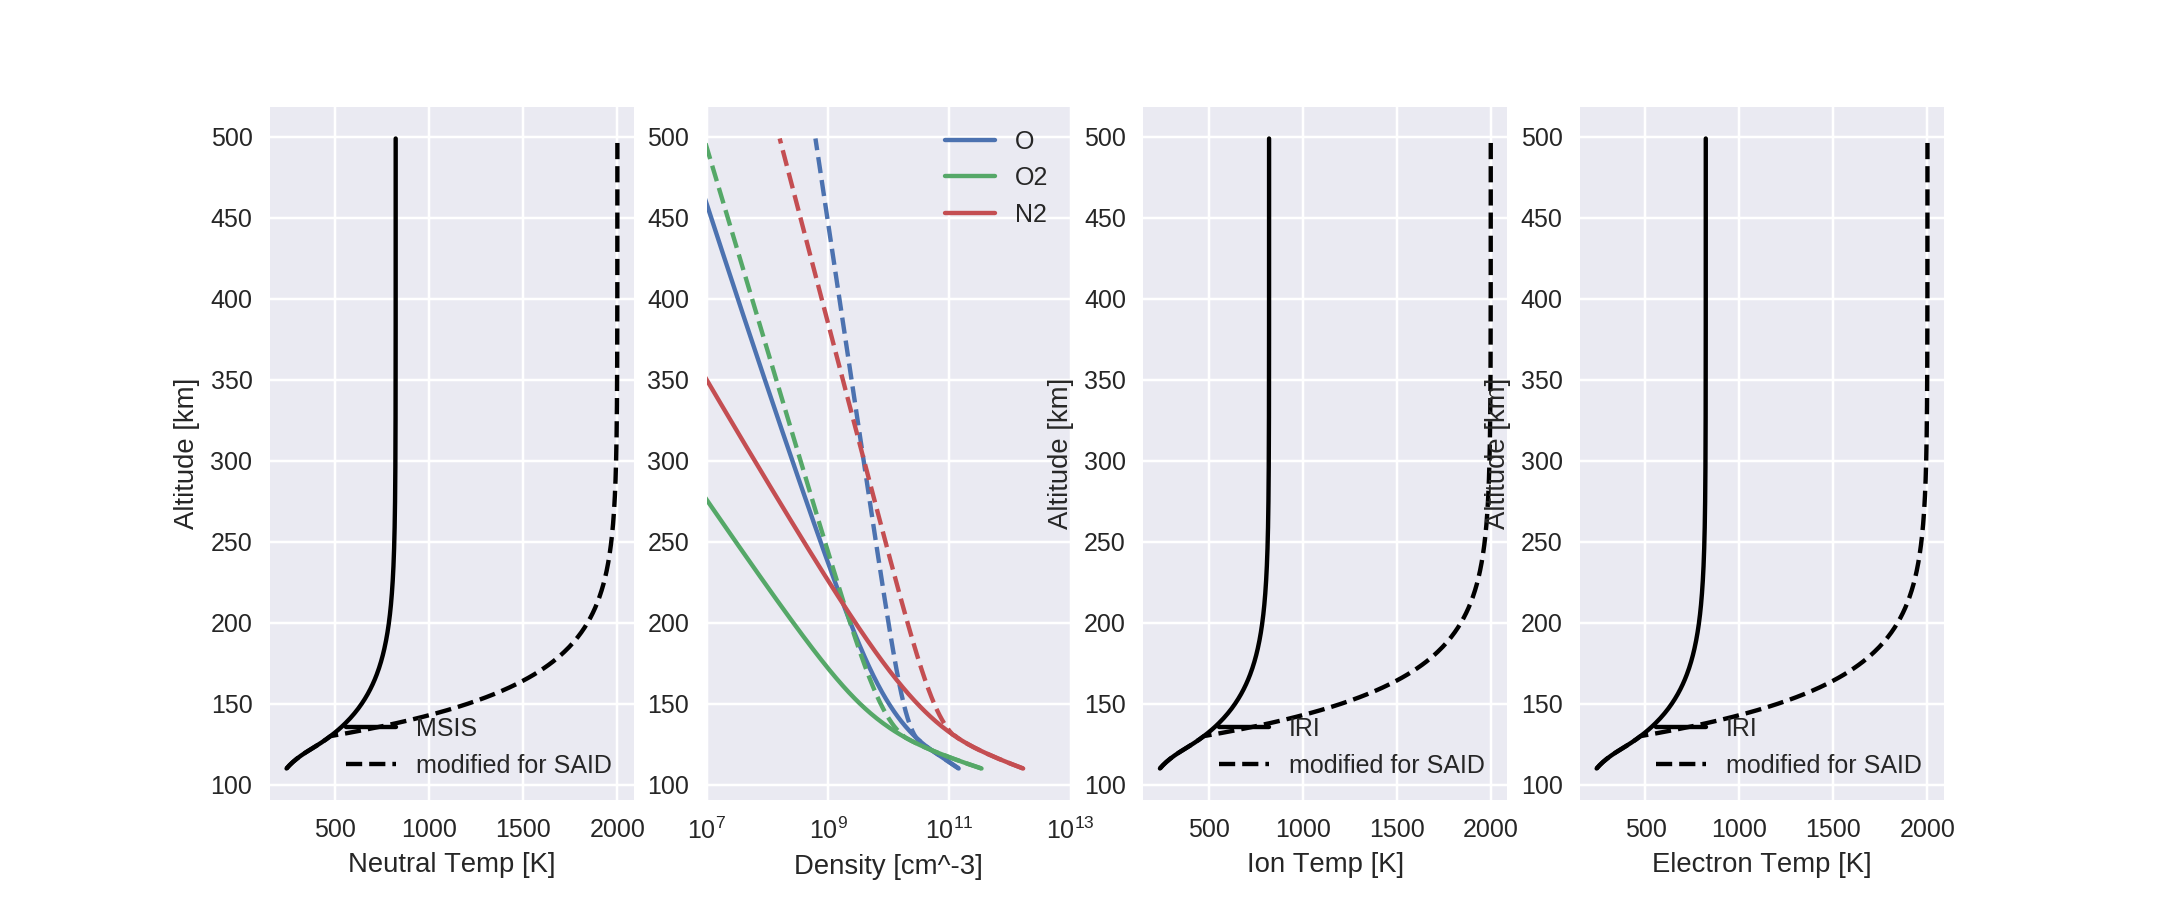

Text(0, 0.5, 'Altitude [km]')

In [21]:
ti0 = 95
ti1 = 100

plt.figure(figsize=(12,5))

plt.subplot(1,4,1)
plt.plot(TnT[ti0], alts, 'k-', label='MSIS')
plt.plot(TnT[ti1],alts, 'k--', label='modified for SAID')
plt.legend()
plt.xlabel('Neutral Temp [K]')
plt.ylabel('Altitude [km]')

plt.subplot(1,4,2)
for i, s in enumerate(['O', 'O2', 'N2']):
    plt.semilogx(nT[ti0,:,sidx[s]], alts, 'C%i-'%i, label=s)
    plt.semilogx(nT[ti1,:,sidx[s]], alts, 'C%i--'%i)
plt.legend()
plt.xlabel('Density [cm^-3]')
plt.xlim((1e7, 1e13))

plt.subplot(1,4,3)
plt.plot(TiT[ti0], alts, 'k-', label='IRI')
plt.plot(TiT[ti1],alts, 'k--', label='modified for SAID')
plt.legend()
plt.xlabel('Ion Temp [K]')
plt.ylabel('Altitude [km]')

plt.subplot(1,4,4)
plt.plot(TeT[ti0], alts, 'k-',  label='IRI')
plt.plot(TeT[ti1], alts, 'k--', label='modified for SAID')
plt.legend()
plt.xlabel('Electron Temp [K]')
plt.ylabel('Altitude [km]')

<IPython.core.display.Javascript object>


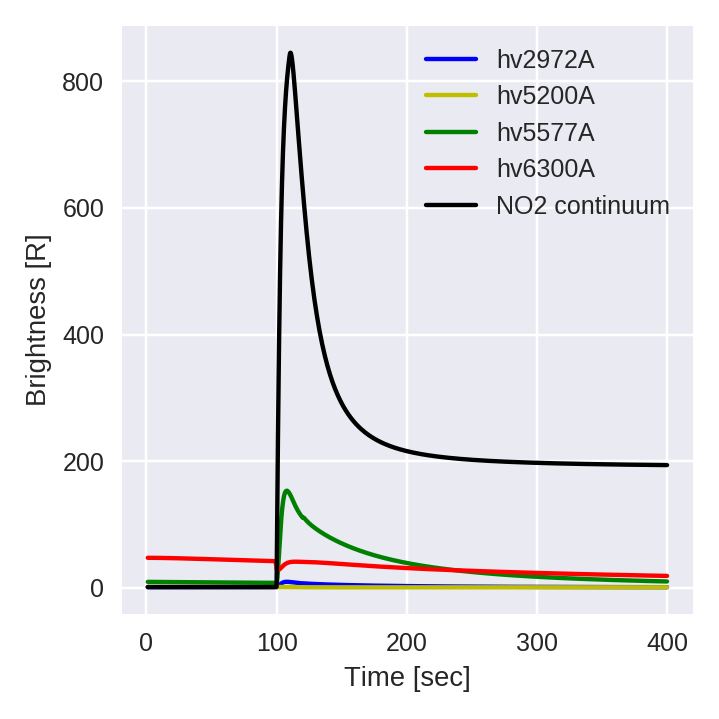

In [22]:
vercolors = {'hv2470A':'gray', 'hv2972A':'b', 'hv3727A':'w', 'hv5200A':'y', 'hv5577A':'g', 'hv6300A':'r', 'hv7320A':'m'}
IT = np.sum(verT, axis=1)*dz*1e-1

kNO2 = 1e-20 # * np.exp(530*(1/296 - 1/Tn)) # Hedin et al (2012) citing Sharp (1984)
vNO2 = kNO2 * nT[:,:,sidx['NO']] * nT[:,:,sidx['O']]
INO2c = np.sum(vNO2, axis=1)*dz*1e-1 
INO2 = INO2c * 400 # for comparing with the 400-800 nm radiance of 6 kR seen by Gillies

plt.figure(figsize=(4,4))
for je, e in enumerate(emissions):
    plt.plot(tT, IT[:,je], '-', color=vercolors[e], label=e)
plt.plot(tT, INO2, 'k-', label='NO2 continuum')
plt.ylabel('Brightness [R]')
plt.xlabel('Time [sec]')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


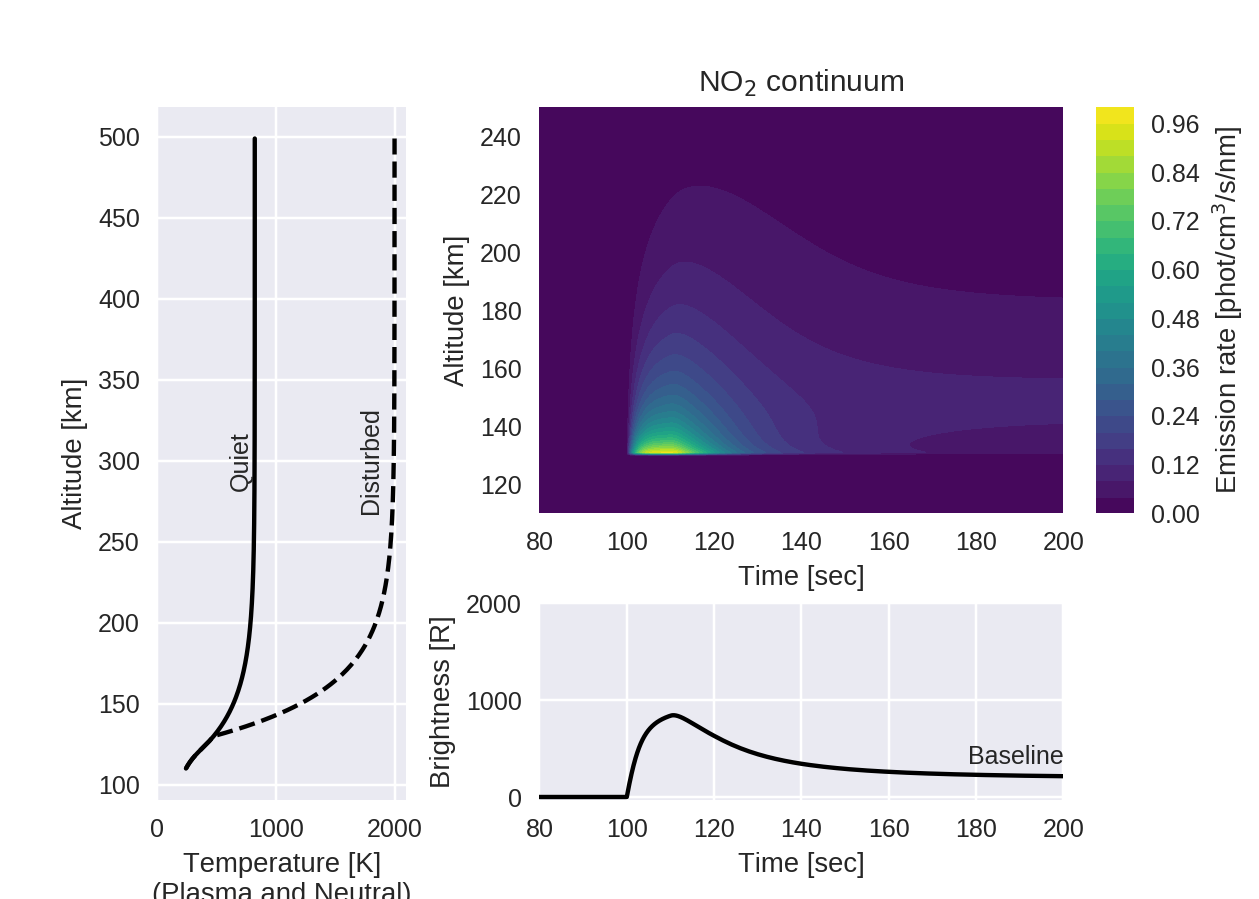

In [23]:
with plt.style.context(('seaborn')):

    fig = plt.figure(figsize=(7,5), constrained_layout=False)
    widths = [1.3,3.0,0.2]
    heights = [2,1.1]
    gs = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                              height_ratios=heights, )

    ax = fig.add_subplot(gs[:,0])
    plt.sca(ax)
    ti0 = 95
    ti1 = 100
    ax.plot(TeT[ti0], alts, 'k-', label='Quiet')
    ax.plot(TnT[ti1], alts, 'k--', label='Disturbed')
    # ax.legend()
    ax.set_xlabel('Temperature [K]\n(Plasma and Neutral)')
    ax.set_ylabel('Altitude [km]')
    ax.set_xlim((0,2100))
    ax.set_xticks([0,1000,2000])
    ax.text(700,300,'Quiet',ha='center',va='center',rotation=90)
    ax.text(1800,300,'Disturbed',ha='center',va='center',rotation=90)
    
    # Colorbar
    cax = fig.add_subplot(gs[0,2])
#     pos1 = cax.get_position() # get the original position 
#     pos2 = [pos1.x0-0.5, pos1.y0 ,  pos1.width , pos1.height ] 
#     cax.set_position(pos2) # set a new position
    
    ax = fig.add_subplot(gs[0,1])
    plt.sca(ax)
    m = ax.contourf(tT[:], alts, vNO2[:, :].T, cmap='viridis', levels=30)
    ax.set_ylim((110, 250))
    ax.set_xlim((80,200))
    ax.set_title(r'NO$_2$ continuum')
    ax.set_ylabel('Altitude [km]')
    ax.set_xlabel('Time [sec]')
    plt.colorbar(mappable=m, cax=cax, label='Emission rate [phot/cm$^3$/s/nm]')
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0+0.06, pos1.y0 ,  pos1.width-0.04 , pos1.height ] 
    ax.set_position(pos2) # set a new position

    ax = fig.add_subplot(gs[1,1])
#     ax.plot(tT, INO2_noN, 'k--', dashes=(1,1), label='Without N production') # The run without N production was done and saved separately
    ax.plot(tT, INO2, 'k-', label='With N production')
    ax.set_ylabel('Brightness [R]')
    ax.set_xlabel('Time [sec]')
    ax.set_xlim((80,200))
    ax.set_ylim((-30,2000))
#     ax.text(200, INO2_noN[-40]-100, 'Without N production', ha='right', va='top',) # The run without N production was done and saved separately
    ax.text(200, INO2[-40]+100,     'Baseline', ha='right', va='bottom',)
    # ax.legend()
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0+0.06, pos1.y0 ,  pos1.width-0.04 , pos1.height-0.03 ] 
    ax.set_position(pos2) # set a new position
    
#     plt.tight_layout()
#     fig.tight_layout(w_pad=-15)
#     plt.savefig('/home/bharding/public_html/STEVE/model.png', dpi=500)#, bbox_inches='tight')